Graphs to make:
- [V] 1. Lissajous overview
- [ ] 2. Single representative Lissajous
- [V] 3. Current/Voltage profile overview
- [ ] 4. Single representative current/voltage profile

Step 0: import libraries and create static variables

In [72]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from matplotlib.patches import FancyArrowPatch

In [73]:
# Define the alpha value for the post-plasma materials
alpha = 0.75

# Define the color for each material
packing_colors = {
    'SiO₂@TiO₂  3 h': (86/255, 180/255, 233/255),
    'SiO₂@TiO₂  6 h': (0/255, 114/255, 178/255),
    'SiO₂@TiO₂  9 h': (230/255, 159/255, 0/255),
    'SiO₂@TiO₂ 12 h': (213/255, 94/255, 0/255)
}

# determine order of materials for plotting
packing_order = [
    'SiO₂@TiO₂  3 h',
    'SiO₂@TiO₂  6 h',
    'SiO₂@TiO₂  9 h',
    'SiO₂@TiO₂ 12 h',      
]

In [74]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 7

In [75]:
# set the folder and file name
folder_path = r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign\co2-splitting\uhasselt'

Step 1: Import & prepare calculated electrical data

In [76]:
file_name = 'uhasselt_co2_spl_electrical_data_combined.csv'
file_path = os.path.join(folder_path, file_name)

# read the Excel file
df = pd.read_csv(file_path)

In [77]:
df_mean = df[
    (df['residence_time_s'] <= 80) &
    (df['plasma_state'] == 'plasma')
].assign(
    material_name=lambda x: x['material_name'].map(
        {
            'SiO2@Anatase_TiO2-220-03H': 'SiO₂@TiO₂  3 h',
            'SiO2@Anatase_TiO2-220-06H': 'SiO₂@TiO₂  6 h',
            'SiO2@Anatase_TiO2-220-09H': 'SiO₂@TiO₂  9 h',
            'SiO2@Anatase_TiO2-220-12H': 'SiO₂@TiO₂ 12 h'
        }
    ),
    U_pp_kV=lambda x: x['U_pp_V']/1000,
    displaced_charge_nC=lambda x: x['displaced_charge_C']*1e9,
    sei_kjmol=lambda x: (x['plasma_power_W'] / 
                         (
                          (1 - 0.4774) *
                          (17.31 / x['residence_time_s'])
                         ) * 24.055
                        ),
    plasma_rms_current_mA=lambda x: x['plasma_rms_current_A']*1e3,
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4774)*(17.31/x['residence_time_s']))*24.055,
        ndigits=-1
    ).astype(int),
    eff_cap_pF=lambda x: x['slope_DA_F'] * 1e12
).query(
    'material_name in ["SiO₂@TiO₂  3 h", "SiO₂@TiO₂  6 h", "SiO₂@TiO₂  9 h", "SiO₂@TiO₂ 12 h"]'
).groupby(
    ['material_name', 'sei_ideal_kjmol']
).agg(
    U_pp_kV=('U_pp_kV', 'mean'),
    U_pp_kV_err=(
        'U_pp_kV',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    avg_num_udisch_per_graph=('avg_num_udisch_per_graph', 'mean'),
    avg_num_udisch_per_graph_err=(
        'avg_num_udisch_per_graph',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    displaced_charge_nC=('displaced_charge_nC', 'mean'),
    displaced_charge_nC_err=(
        'displaced_charge_nC',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    plasma_rms_current_mA=('plasma_rms_current_mA', 'mean'),
    plasma_rms_current_mA_err=(
        'plasma_rms_current_mA',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    eff_cap_pF=('eff_cap_pF', 'mean'),
    eff_cap_pF_err=(
        'eff_cap_pF',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    )
).reset_index(
).copy()

Step 1.1: U_pp vs SEI

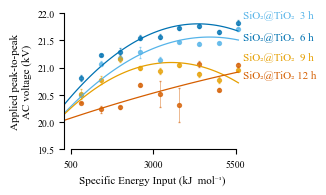

In [78]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="U_pp_kV",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=2,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Applied peak-to-peak\nAC voltage (kV)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['U_pp_kV'],
        yerr=subset['U_pp_kV_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂@TiO₂  3 h': (5600, 21.9),
    'SiO₂@TiO₂  6 h': (5600, 21.5),
    'SiO₂@TiO₂  9 h': (5600, 21.14),
    'SiO₂@TiO₂ 12 h':  (5600, 20.8)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(300, 5650)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(19.5, 22)
ax.spines['left'].set_bounds(19.5, 22)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_U_pp_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.2: Displaced Q vs SEI

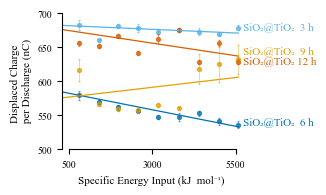

In [79]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="displaced_charge_nC",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Displaced Charge \n per Discharge (nC)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['displaced_charge_nC'],
        yerr=subset['displaced_charge_nC_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂@TiO₂  3 h': (5600, 675),
    'SiO₂@TiO₂  6 h': (5600, 536),
    'SiO₂@TiO₂  9 h': (5600, 640),
    'SiO₂@TiO₂ 12 h':  (5600, 625)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(300, 5650)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(500, 700)
ax.spines['left'].set_bounds(500, 700)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_displ_Q_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.3: plasma_current_rms vs SEI

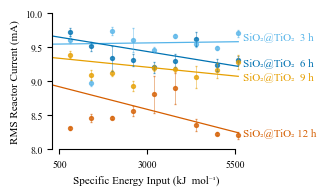

In [80]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="plasma_rms_current_mA",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("RMS Reactor Current (mA)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['plasma_rms_current_mA'],
        yerr=subset['plasma_rms_current_mA_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂@TiO₂  3 h': (5600, 9.6),
    'SiO₂@TiO₂  6 h': (5600, 9.22),
    'SiO₂@TiO₂  9 h': (5600, 9.02),
    'SiO₂@TiO₂ 12 h':  (5600, 8.2)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(300, 5650)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(8, 10)
ax.spines['left'].set_bounds(8, 10)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_rms_reactor_I_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.4: avg_num_udisch vs SEI

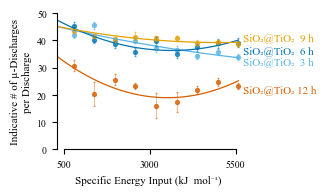

In [81]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="avg_num_udisch_per_graph",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=2,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Indicative # of µ-Discharges\nper Discharge", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['avg_num_udisch_per_graph'],
        yerr=subset['avg_num_udisch_per_graph_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂@TiO₂  3 h': (5600, 31),
    'SiO₂@TiO₂  6 h': (5600, 35),
    'SiO₂@TiO₂  9 h': (5600, 39.8),
    'SiO₂@TiO₂ 12 h':  (5600, 20.5)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(300, 5650)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(0, 50)
ax.spines['left'].set_bounds(0, 50)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_avg_num_udisch_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.5: Effective Q vs SEI

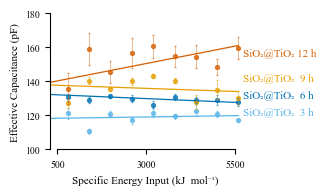

In [82]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="eff_cap_pF",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Effective Capacitance (pF)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['eff_cap_pF'],
        yerr=subset['eff_cap_pF_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂@TiO₂  3 h': (5600, 117),
    'SiO₂@TiO₂  6 h': (5600, 125),
    'SiO₂@TiO₂  9 h': (5600, 130),
    'SiO₂@TiO₂ 12 h':  (5600, 158)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(300, 5650)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(100, 180)
ax.spines['left'].set_bounds(100, 180)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_eff_cap_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 2: Import & prepare Lissajous data

In [83]:
file_name = 'uhasselt_co2_spl_lissajous_data_combined.csv'
file_path = os.path.join(folder_path, file_name)

# read the Excel file
df_lissajous_temp = pd.read_csv(file_path)

In [84]:
df_lissajous= df_lissajous_temp[
    (df_lissajous_temp['residence_time_s'] <= 80) &
    (df_lissajous_temp['plasma_state'] == 'plasma')
].query(
    'material_name in ["SiO2@Anatase_TiO2-220-03H", "SiO2@Anatase_TiO2-220-06H", "SiO2@Anatase_TiO2-220-09H", "SiO2@Anatase_TiO2-220-12H"]'
).assign(
    material_name=lambda x: x['material_name'].map(
        {
            'SiO2@Anatase_TiO2-220-03H': 'SiO₂@TiO₂  3 h',
            'SiO2@Anatase_TiO2-220-06H': 'SiO₂@TiO₂  6 h',
            'SiO2@Anatase_TiO2-220-09H': 'SiO₂@TiO₂  9 h',
            'SiO2@Anatase_TiO2-220-12H': 'SiO₂@TiO₂ 12 h'
        }
    ),
    voltage_kV=lambda x: x['voltage_V']/1000,
    charge_nC=lambda x: x['charge_C']*1e9,
    sei_ideal_kjmol=lambda x: round(
        number=30 / ((1 - 0.4774) * (17.31 / x['residence_time_s'])) * 24.055,
        ndigits=-1
    ).astype(int)
).groupby(
    ['material_name', 'residence_time_s', 'sei_ideal_kjmol', 'time_s']
).agg(
    voltage_kV=('voltage_kV', 'mean'),
    charge_nC=('charge_nC', 'mean')
).reset_index(
).copy()

Step 2.1: Lissajous overview

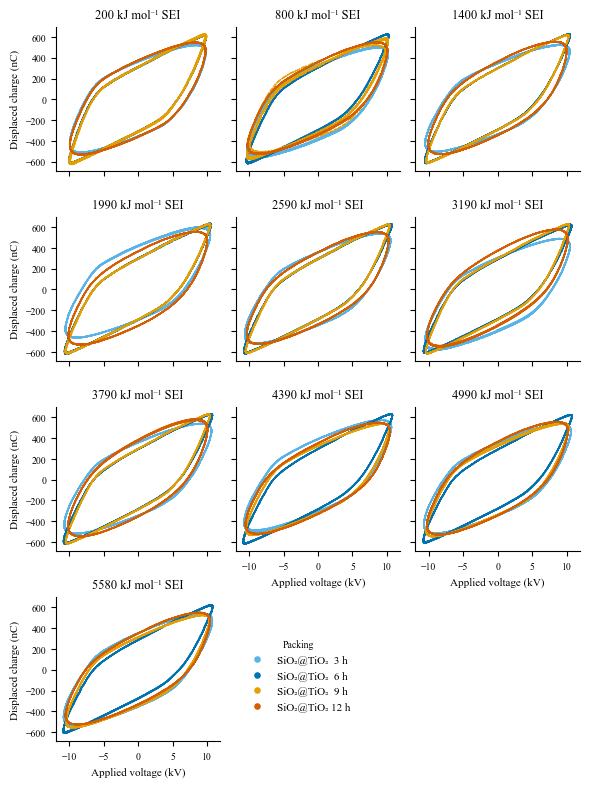

In [85]:
g = sns.relplot(
    data=df_lissajous,
    x='voltage_kV',
    y='charge_nC',
    hue='material_name',
    hue_order=packing_order,
    palette=packing_colors,
    kind='scatter',
    col='sei_ideal_kjmol',
    col_wrap=3,
    height=5/2.54,
    aspect=1,
    s=0.9,
    legend=True,
    facet_kws={'legend_out': False},
    edgecolor = None
)

sns.move_legend(
    g,
    loc='upper left',
    title='Packing',
    bbox_to_anchor=(0.40, 0.20),
    frameon=False,
    fontsize=8,
    markerscale=5
)

g.set_titles(col_template="{col_name} kJ mol⁻¹ SEI", size=9)
g.set_xlabels("Applied voltage (kV)", size=8)
g.set_ylabels("Displaced charge (nC)", size=8)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_lissajous_overview.pdf",
    bbox_inches='tight'
)
plt.show()

Step 2.2: Single representative Lissajous

Step 3: Import current/voltage profile data

In [86]:
# Step 1: load the data
file_name = 'uhasselt_co2_spl_current_voltage_profile_data_combined.csv'
file_path = os.path.join(folder_path, file_name)

# read the .csv file
df_current_voltage_temp = pd.read_csv(file_path)

MemoryError: Unable to allocate 570. MiB for an array with shape (8, 9345221) and data type object

In [ ]:
df_current_voltage= df_current_voltage_temp[
    (df_current_voltage_temp['residence_time_s'] <= 80) &
    (df_current_voltage_temp['plasma_state'] == 'plasma')
].query(
    'material_name in ["SiO2@Anatase_TiO2-220-03H", "SiO2@Anatase_TiO2-220-06H", "SiO2@Anatase_TiO2-220-09H", "SiO2@Anatase_TiO2-220-12H"]'
).assign(
    material_name=lambda x: x['material_name'].map(
        {
            'SiO2@Anatase_TiO2-220-03H': 'SiO₂@TiO₂  3 h',
            'SiO2@Anatase_TiO2-220-06H': 'SiO₂@TiO₂  6 h',
            'SiO2@Anatase_TiO2-220-09H': 'SiO₂@TiO₂  9 h',
            'SiO2@Anatase_TiO2-220-12H': 'SiO₂@TiO₂ 12 h'
        }
    ),
    time_us=lambda x: x['time_s'] * 1e6,
    current_plasma_mA=lambda x: x['current_plasma_A'] * 1e3,
    voltage_kV=lambda x: x['voltage_V']/1000,
    sei_ideal_kjmol=lambda x: round(
        number=30/((1-0.4774)*(17.31/x['residence_time_s']))*24.055,
        ndigits=-1
    ).astype(int)
).reset_index(
).copy()

# Determine for every group of material_name and sei_ideal_kjmol
# the values for which the measurement_number variable is largest
# and select only those rows
df_current_voltage_filtered = df_current_voltage[
    df_current_voltage.groupby(
        ['material_name', 'sei_ideal_kjmol']
    )['measurement_number'].transform(
        "max"
    ) == df_current_voltage['measurement_number']
].reset_index(drop=True).copy()

# Select for every group of material_name and sei_ideal_kjmol
# a random psdata_file_name and select only those rows

# Step 1: Generate a random psdata_file_name for each group
# Create a DataFrame with a random psdata_file_name
# for each combination of material_name and sei_ideal_kjmol
def random_psdata(group):
    return pd.Series({
        'random_psdata_file_name': np.random.choice(group['psdata_file_name'])
    })

random_psdata_mappings = df_current_voltage_filtered.groupby(
    ['material_name', 'sei_ideal_kjmol']
    ).apply(
        random_psdata,
        include_groups=False
    ).reset_index()

# Step 2: Merge this random selection back to the original DataFrame
# This filters for rows where the psdata_file_name matches
# the randomly selected psdata_file_name for each group
# Merge the random psdata_file_name selection with original DataFrame
df_final_filtered = pd.merge(
    df_current_voltage_filtered,
    random_psdata_mappings,
    on=['material_name', 'sei_ideal_kjmol'],
    how='inner'
)

# Filter rows to match the randomly selected psdata_file_name
df_final_filtered = df_final_filtered[
    df_final_filtered['psdata_file_name']
    == df_final_filtered['random_psdata_file_name']
]

# Drop the 'random_psdata_file_name' column as it's no longer needed
df_final_filtered.drop(columns=['random_psdata_file_name'], inplace=True)

Step 3.1: Current/Voltage profile overview

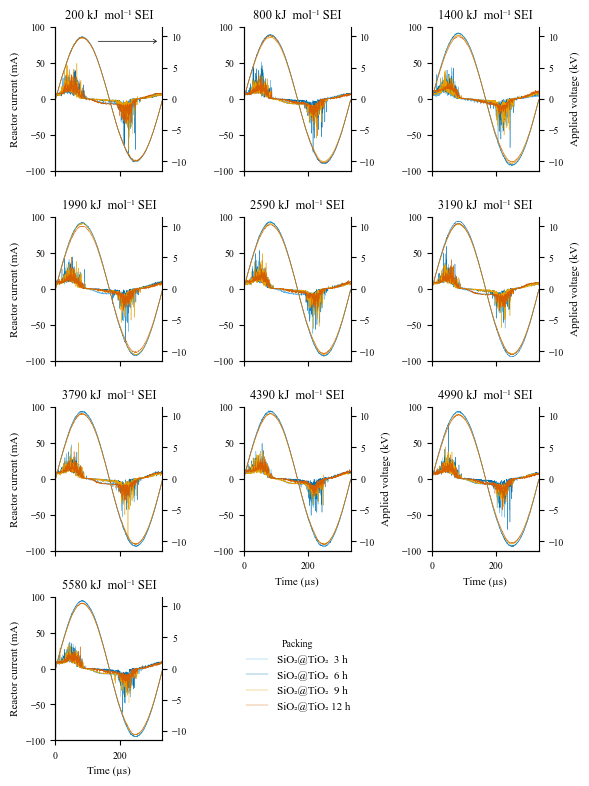

In [ ]:
g = sns.relplot(
    data=df_final_filtered,
    x='time_us',
    y='current_plasma_mA',
    hue='material_name',
    hue_order=packing_order,
    palette=packing_colors,
    kind='line',
    col='sei_ideal_kjmol',
    col_wrap=3,
    height=5/2.54,
    aspect=1,
    legend=True,
    facet_kws={'legend_out': False},
    linewidth=0.275,
    estimator=None
)

# set the x-axis limits
g.set(xlim=(0, 333))

# set the y-axis limits
g.set(ylim=(-100, 100))

# set titles and labels
g.set_titles(col_template="{col_name} kJ  mol⁻¹ SEI", size=9)
g.set_xlabels("Time (µs)", size=8)
g.set_ylabels("Reactor current (mA)", size=8)

# Define a list of subplot indices that have the custom y-axis label
label_indices = [2, 5, 7]

# Iterate over each subplot in the FacetGrid to add a second y-axis
for i, (ax, (name, group)) in enumerate(
    zip(g.axes.flat, df_final_filtered.groupby('sei_ideal_kjmol'))
    ):
    # Create a twin y-axis for the current subplot
    ax2 = ax.twinx()
    
    # Plot your second variable ('voltage_kV') on the twin y-axis
    # Note: You will need to filter 'group' for the specific subplot
    # based on 'residence_time_s' and possibly other conditions
    sns.lineplot(
        data=group,
        x='time_us',
        y='voltage_kV',
        ax=ax2,
        hue='material_name',
        hue_order=packing_order,
        palette=packing_colors,
        legend=False,
        linewidth=0.45,
        alpha=0.8
    )
    
    # Set the label for the twin y-axis
    # based on the current subplot index
    if i in label_indices:
        ax2.set_ylabel("Applied voltage (kV)", fontsize=8)
    else:
        ax2.set_ylabel("", fontsize=8)
    
    # Adjust the twin y-axis tick parameters
    ax2.set_ylim(-11.5, 11.5)
    ax2.tick_params(axis='y', labelsize=7)
    
    sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False)
    
    # Ensure the twin y-axis does not interfere with the layout
    ax.figure.tight_layout()

ax01 = g.axes.flatten()[0]

arrow = FancyArrowPatch((125, 80), (325, 80),
                        arrowstyle='->,head_width=1.5,head_length=2.25',
                        color='black',
                        lw=0.5)

# Add the arrow to the plot
ax01.add_patch(arrow)

sns.move_legend(
    g,
    loc='upper left',
    title='Packing',
    bbox_to_anchor=(0.40, 0.20),
    frameon=False,
    fontsize=8
)

plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_coating\figs\sander_IU_profile_overview.pdf",
    bbox_inches='tight'
)
plt.show()

Step 3.2: Single representative current/voltage profile

In [ ]:
# Close all figures
#plt.close('all')

# Clear all variables
#%reset -f